# Assignment 4

## Setup

In [50]:
! pip3 install -r requirements.txt

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, load_wine
from ucimlrepo import fetch_ucirepo 
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
import itertools
import time
import json
import os

## Load data

In [52]:
# Wine dataset
X, y = load_wine(return_X_y=True, as_frame=True)
wine_df = X.copy()
wine_df['target'] = y
print(wine_df.shape)
display(wine_df.head())


(178, 14)


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [53]:

# Adult income dataset
adult = fetch_ucirepo(id=2)
X = adult.data.features 
y = adult.data.targets 
adult_df = X.copy()
adult_df['target'] = y
print(adult_df.shape)
display(adult_df.head())



(48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [54]:
# MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target
mnist_df = X.copy()
mnist_df['target'] = y
print(mnist_df.shape)
display(mnist_df.head())

(70000, 785)


,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


## Pre-processing

In [55]:
# # Pre-processing Iris dataset

# iris_features = iris_df.drop('target', axis=1)
# iris_target = iris_df['target']

# # Split before scaling to avoid data leakage
# # X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
# #     iris_features, iris_target, test_size=0.2, random_state=42
# # )

# iris_pipeline = Pipeline([
#     ('scaler', StandardScaler())
# ])

# # Fit only on training data
# # X_train_iris_scaled = iris_pipeline.fit_transform(X_train_iris)
# # X_test_iris_scaled = iris_pipeline.transform(X_test_iris)

# X_iris_scaled = iris_pipeline.fit_transform(iris_features)  # full scaled features
# y_iris = iris_target.values  # full target

In [56]:
# Pre-processing Wine dataset

wine_features = wine_df.drop('target', axis=1)
wine_target = wine_df['target']

# # Split before scaling
# X_train_wine, X_test_wine, y_train_wine, y_test_wine = train_test_split(
#     wine_features, wine_target, test_size=0.2, random_state=42
# )

wine_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# # Fit only on training data
# X_train_wine_scaled = wine_pipeline.fit_transform(X_train_wine)
# X_test_wine_scaled = wine_pipeline.transform(X_test_wine)

X_wine_scaled = wine_pipeline.fit_transform(wine_features)
y_wine = wine_target.values

In [57]:
# Pre process Adult Income dataset

# After cleaning and encoding target
adult_df = adult_df.replace('?', np.nan).dropna()
adult_df['target'] = adult_df['target'].astype(str).str.strip().str.replace('.', '', regex=False)
adult_df['target'] = adult_df['target'].map({'<=50K': 0, '>50K': 1})

# Drop rows where target could not be mapped (i.e., is NaN)
adult_df = adult_df.dropna(subset=['target'])

# Optional: sample for speed
adult_df_sampled, _ = train_test_split(
    adult_df,
    train_size=10000,
    stratify=adult_df['target'],
    random_state=42
)

# Prepare features and target for CV
adult_features = adult_df_sampled.drop('target', axis=1)
adult_target = adult_df_sampled['target'].values

# Identify columns
categorical_cols = adult_features.select_dtypes(include=['object', 'category']).columns
numerical_cols = adult_features.select_dtypes(include=['number']).columns

adult_preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

# Fit and transform on the full sampled data
X_adult_processed = adult_preprocessor.fit_transform(adult_features)

In [58]:
# Pre-process MNIST dataset
mnist_features = mnist_df.drop('target', axis=1)
mnist_target = mnist_df['target'].astype(int)

# Sample 10,000 rows for speed
mnist_sampled, _ = train_test_split(
    mnist_df, 
    train_size=10000, 
    random_state=42, 
    stratify=mnist_df['target']
)
mnist_features_sampled = mnist_sampled.drop('target', axis=1)
mnist_target_sampled = mnist_sampled['target'].astype(int)

mnist_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Fit and transform on the full sampled data
X_mnist_scaled = mnist_pipeline.fit_transform(mnist_features_sampled)
y_mnist = mnist_target_sampled.values

## Experiment 1

Vary tree depth: 

- Keep number of decision trees in random forest fixed.
- Keep number of descriptive features to split on fixed.
- Keep bag size fixed.

Results: Accuracy vs tree depth

In [59]:
def run_tree_depth_experiment(
    X, y,
    depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, None],
    n_estimators=100,
    max_features='sqrt',
    random_state=42,
    results_dir='experiment_1',
    dataset_name='dataset',
    cv=10
):
    """
    Runs an experiment varying max tree depth for a Random Forest using cross-validation.
    Tracks mean and std of metrics over folds. Saves metrics to a JSON file.
    """
    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for depth in depths:
        fold_accuracies = []
        fold_f1s = []
        fold_stddevs = []
        fold_cms = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=depth,
                max_features=max_features,
                random_state=random_state,
                class_weight='balanced'
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)
            if hasattr(clf, "predict_proba"):
                proba = clf.predict_proba(X_test)
                std_dev = float(np.std(proba))
            else:
                std_dev = None
            fold_accuracies.append(acc)
            fold_f1s.append(f1)
            fold_stddevs.append(std_dev)
            fold_cms.append(cm.tolist())
        metrics.append({
            'max_depth': depth if depth is not None else 'None',
            'accuracy_mean': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies),
            'f1_mean': np.mean(fold_f1s),
            'f1_std': np.std(fold_f1s),
            'std_dev_mean': np.mean([v for v in fold_stddevs if v is not None]),
            'std_dev_std': np.std([v for v in fold_stddevs if v is not None]),
            'confusion_matrices': fold_cms
        })
        print(f"Depth: {depth}, Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}, "
              f"F1: {np.mean(fold_f1s):.3f} ± {np.std(fold_f1s):.3f}")
    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/rf_tree_depth_cv_metrics__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

In [60]:
def plot_depth_vs_accuracy(filename):    
    # Load metrics from file
    with open(filename, 'r') as f:
        metrics = json.load(f)

    # Extract tree depths and mean/std accuracies
    depths = [m['max_depth'] if m['max_depth'] != 'None' else None for m in metrics]
    accuracies_mean = [m['accuracy_mean'] for m in metrics]
    accuracies_std = [m['accuracy_std'] for m in metrics]

    # Convert 'None' to a label for plotting
    depth_labels = [str(d) if d is not None else 'None' for d in depths]

    plt.figure(figsize=(8, 5))
    plt.errorbar(depth_labels, accuracies_mean, yerr=accuracies_std, marker='o', capsize=4)
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Accuracy (Mean ± Std, CV)')
    plt.title('Accuracy vs Tree Depth (Cross-Validation)')
    plt.grid(True)
    plt.show()

Depth: 1, Accuracy: 0.944 ± 0.035, F1: 0.943 ± 0.037
Depth: 2, Accuracy: 0.978 ± 0.037, F1: 0.977 ± 0.038
Depth: 3, Accuracy: 0.989 ± 0.022, F1: 0.989 ± 0.022
Depth: 4, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 5, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 6, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 7, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 8, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 9, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 10, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 15, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 20, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 25, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: 30, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Depth: None, Accuracy: 0.983 ± 0.036, F1: 0.983 ± 0.036
Metrics saved to experiment_1/rf_tree_depth_cv_metrics__wine__20251021-094341.json


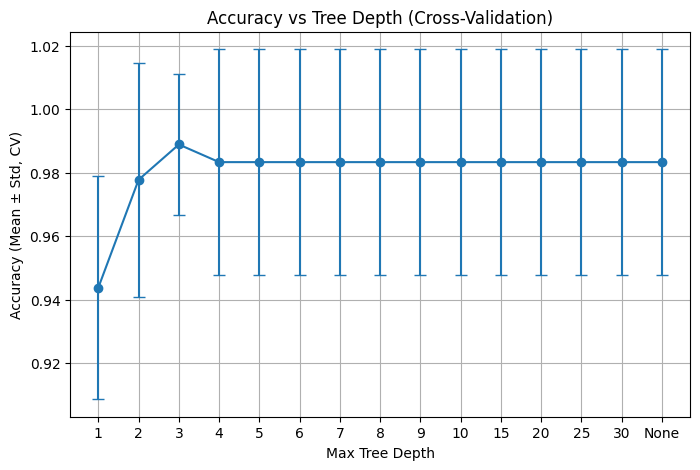

In [61]:
# Wine experiment
wine_metrics, wine_filename = run_tree_depth_experiment(
    X_wine_scaled, y_wine,
    results_dir='experiment_1',
    dataset_name='wine'
)

plot_depth_vs_accuracy(wine_filename)

Depth: 1, Accuracy: 0.740 ± 0.011, F1: 0.757 ± 0.010
Depth: 2, Accuracy: 0.737 ± 0.009, F1: 0.755 ± 0.009
Depth: 3, Accuracy: 0.742 ± 0.009, F1: 0.759 ± 0.008
Depth: 4, Accuracy: 0.747 ± 0.011, F1: 0.764 ± 0.010
Depth: 5, Accuracy: 0.754 ± 0.011, F1: 0.770 ± 0.010
Depth: 6, Accuracy: 0.764 ± 0.010, F1: 0.779 ± 0.009
Depth: 7, Accuracy: 0.774 ± 0.010, F1: 0.789 ± 0.009
Depth: 8, Accuracy: 0.789 ± 0.011, F1: 0.801 ± 0.010
Depth: 9, Accuracy: 0.796 ± 0.012, F1: 0.808 ± 0.011
Depth: 10, Accuracy: 0.802 ± 0.012, F1: 0.814 ± 0.011
Depth: 15, Accuracy: 0.824 ± 0.014, F1: 0.832 ± 0.013
Depth: 20, Accuracy: 0.839 ± 0.012, F1: 0.843 ± 0.011
Depth: 25, Accuracy: 0.846 ± 0.013, F1: 0.848 ± 0.012
Depth: 30, Accuracy: 0.850 ± 0.010, F1: 0.848 ± 0.010
Depth: None, Accuracy: 0.852 ± 0.006, F1: 0.848 ± 0.006
Metrics saved to experiment_1/rf_tree_depth_cv_metrics__adult_income__20251021-094451.json


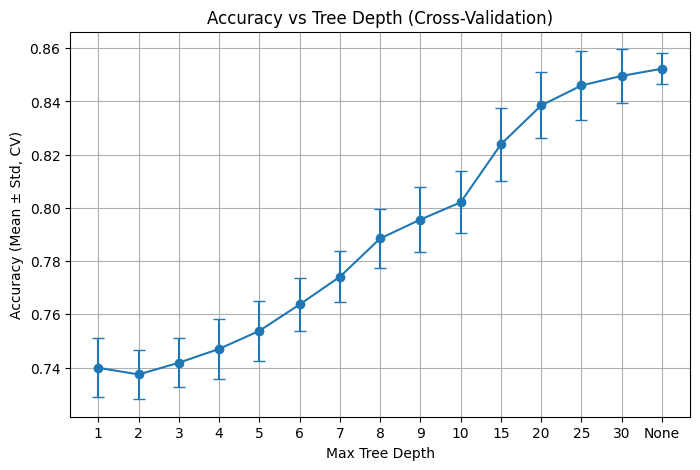

In [62]:
# Adult Income experiment
adult_metrics, adult_filename = run_tree_depth_experiment(
    X_adult_processed, adult_target,
    results_dir='experiment_1',
    dataset_name='adult_income'
)

plot_depth_vs_accuracy(adult_filename)

Depth: 1, Accuracy: 0.539 ± 0.012, F1: 0.497 ± 0.015
Depth: 2, Accuracy: 0.673 ± 0.012, F1: 0.654 ± 0.013
Depth: 3, Accuracy: 0.764 ± 0.013, F1: 0.754 ± 0.014
Depth: 4, Accuracy: 0.827 ± 0.008, F1: 0.823 ± 0.008
Depth: 5, Accuracy: 0.863 ± 0.008, F1: 0.861 ± 0.008
Depth: 6, Accuracy: 0.889 ± 0.006, F1: 0.888 ± 0.007
Depth: 7, Accuracy: 0.908 ± 0.007, F1: 0.907 ± 0.007
Depth: 8, Accuracy: 0.922 ± 0.007, F1: 0.922 ± 0.007
Depth: 9, Accuracy: 0.932 ± 0.006, F1: 0.932 ± 0.006
Depth: 10, Accuracy: 0.938 ± 0.006, F1: 0.938 ± 0.006
Depth: 15, Accuracy: 0.947 ± 0.006, F1: 0.947 ± 0.006
Depth: 20, Accuracy: 0.947 ± 0.006, F1: 0.947 ± 0.006
Depth: 25, Accuracy: 0.949 ± 0.004, F1: 0.949 ± 0.004
Depth: 30, Accuracy: 0.949 ± 0.004, F1: 0.949 ± 0.004
Depth: None, Accuracy: 0.949 ± 0.004, F1: 0.949 ± 0.004
Metrics saved to experiment_1/rf_tree_depth_cv_metrics__mnist__20251021-094828.json


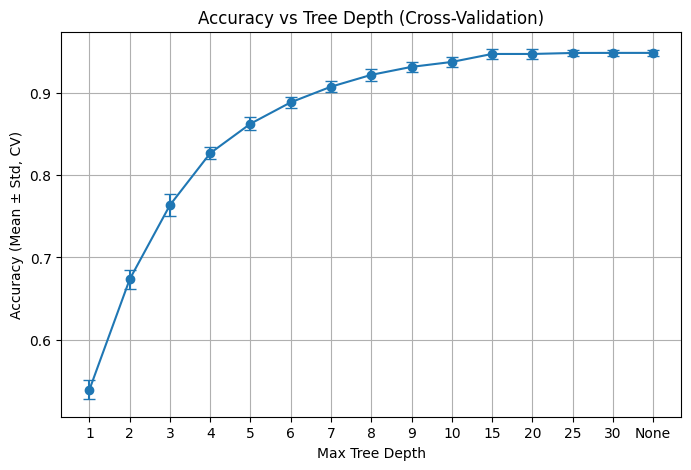

In [63]:
# MNIST experiment
mnist_metrics, mnist_filename = run_tree_depth_experiment(
    X_mnist_scaled, y_mnist,
    dataset_name='mnist'
)

plot_depth_vs_accuracy(mnist_filename)

In [68]:
def plot_depth_vs_accuracy_multiple(filenames, labels=None, title="Accuracy vs Tree Depth (All Datasets)"):
    """
    Plots depth vs accuracy for multiple datasets on the same grid.
    filenames: list of JSON metric files (from run_tree_depth_experiment)
    labels: list of labels for each dataset (optional)
    """
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(filenames))]
    plt.figure(figsize=(10, 6))
    for i, filename in enumerate(filenames):
        with open(filename, 'r') as f:
            metrics = json.load(f)
        depths = [m['max_depth'] if m['max_depth'] != 'None' else None for m in metrics]
        accuracies_mean = [m['accuracy_mean'] for m in metrics]
        accuracies_std = [m['accuracy_std'] for m in metrics]
        # Convert 'None' to a label for plotting
        depth_labels = [str(d) if d is not None else 'None' for d in depths]
        plt.errorbar(depth_labels, accuracies_mean, yerr=accuracies_std, marker='o', capsize=4, label=labels[i])
    plt.xlabel('Max Tree Depth')
    plt.ylabel('Accuracy (Mean ± Std, CV)')
    # plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

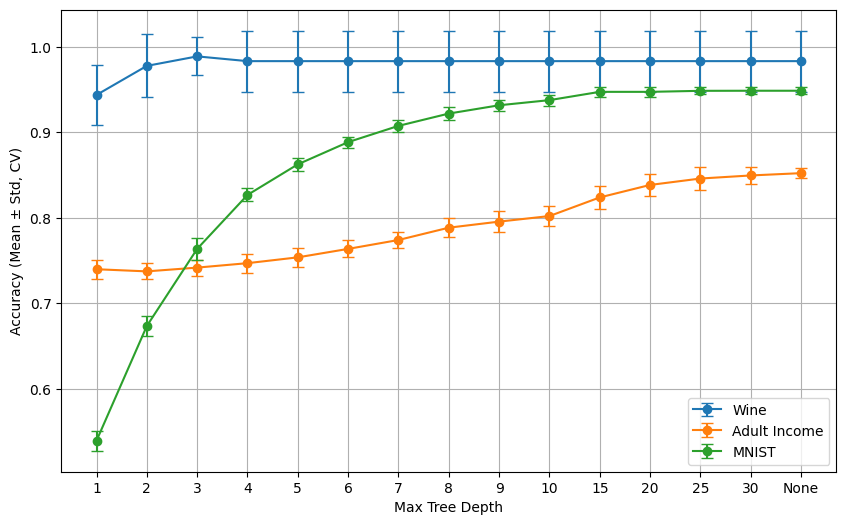

In [69]:
plot_depth_vs_accuracy_multiple(
    [wine_filename, adult_filename, mnist_filename],
    labels=['Wine', 'Adult Income', 'MNIST']
)

## Experiment 2
Relationship between tree depth and number of trees in random forest:

- Fix number of descriptive features to split on fixed.
- Fix bag size.

Cross compare tree depths and number of trees

Results: Heatmap or line plot

In [71]:
def visualize_depth_vs_n_estimators_results(filename):
    """
    Visualizes results from run_depth_vs_n_estimators_experiment.
    Produces a heatmap (accuracy), line plot (accuracy vs n_estimators for each depth),
    and confusion matrix for the best model.
    """
    with open(filename, 'r') as f:
        metrics = json.load(f)

    import pandas as pd
    df = pd.DataFrame(metrics)
    df['max_depth'] = df['max_depth'].replace('None', None)
    df['max_depth'] = df['max_depth'].apply(lambda x: int(x) if x is not None else None)

    # Use mean accuracy from CV
    heatmap_data = df.pivot(index='max_depth', columns='n_estimators', values='accuracy_mean')
    plt.figure(figsize=(8, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis")
    plt.title("Accuracy Heatmap: Tree Depth vs Number of Trees (Mean CV)")
    plt.xlabel("Number of Trees")
    plt.ylabel("Max Tree Depth")
    plt.show()

    # Line plot: accuracy vs n_estimators for each depth
    plt.figure(figsize=(8, 5))
    for depth in sorted(df['max_depth'].dropna().unique()):
        subset = df[df['max_depth'] == depth]
        plt.plot(subset['n_estimators'], subset['accuracy_mean'], marker='o', label=f'Depth {depth}')
    if None in df['max_depth'].values:
        subset = df[df['max_depth'].isnull()]
        plt.plot(subset['n_estimators'], subset['accuracy_mean'], marker='o', label='Depth None')
    plt.xlabel('Number of Trees')
    plt.ylabel('Accuracy (Mean CV)')
    plt.title('Accuracy vs Number of Trees for Each Depth (Mean CV)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Confusion matrix for best model (highest mean accuracy)
    best = max(metrics, key=lambda m: m['accuracy_mean'])
    # Use the first confusion matrix from CV folds
    cm = np.array(best['confusion_matrices'][0])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix (Best Model)\nDepth: {best['max_depth']}, Trees: {best['n_estimators']}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [98]:
def run_depth_vs_n_estimators_experiment(
    X, y,
    depths=[1, 2, 5, 10, 15, 20, 25, 30, 40, 50, None],
    n_estimators_list=[10, 25, 50, 75, 100, 150, 200, 300, 400, 500],
    max_features='sqrt',
    random_state=42,
    results_dir='experiment_2',
    dataset_name='dataset',
    cv=5
):
    """
    Explores the relationship between tree depth and number of trees in a Random Forest using cross-validation.
    Tracks mean and std of metrics over folds. Saves metrics to a JSON file.
    """
    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for depth in depths:
        for n_estimators in n_estimators_list:
            fold_accuracies = []
            fold_f1s = []
            fold_stddevs = []
            fold_cms = []
            for train_idx, test_idx in skf.split(X, y):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]
                clf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=depth,
                    max_features=max_features,
                    random_state=random_state,
                    class_weight='balanced'
                )
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                cm = confusion_matrix(y_test, y_pred)
                if hasattr(clf, "predict_proba"):
                    proba = clf.predict_proba(X_test)
                    std_dev = float(np.std(proba))
                else:
                    std_dev = None
                fold_accuracies.append(acc)
                fold_f1s.append(f1)
                fold_stddevs.append(std_dev)
                fold_cms.append(cm.tolist())
            metrics.append({
                'max_depth': depth if depth is not None else 'None',
                'n_estimators': n_estimators,
                'accuracy_mean': np.mean(fold_accuracies),
                'accuracy_std': np.std(fold_accuracies),
                'f1_mean': np.mean(fold_f1s),
                'f1_std': np.std(fold_f1s),
                'std_dev_mean': np.mean([v for v in fold_stddevs if v is not None]),
                'std_dev_std': np.std([v for v in fold_stddevs if v is not None]),
                'confusion_matrices': fold_cms
            })
            print(f"Depth: {depth}, Trees: {n_estimators}, Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}, F1: {np.mean(fold_f1s):.3f} ± {np.std(fold_f1s):.3f}")
    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/rf_depth_vs_n_estimators_cv__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

Depth: 1, Trees: 10, Accuracy: 0.882 ± 0.022, F1: 0.880 ± 0.021
Depth: 1, Trees: 25, Accuracy: 0.921 ± 0.028, F1: 0.920 ± 0.028
Depth: 1, Trees: 50, Accuracy: 0.921 ± 0.028, F1: 0.920 ± 0.028
Depth: 1, Trees: 75, Accuracy: 0.933 ± 0.014, F1: 0.932 ± 0.014
Depth: 1, Trees: 100, Accuracy: 0.927 ± 0.014, F1: 0.926 ± 0.013
Depth: 1, Trees: 150, Accuracy: 0.938 ± 0.021, F1: 0.938 ± 0.021
Depth: 1, Trees: 200, Accuracy: 0.933 ± 0.014, F1: 0.932 ± 0.014
Depth: 1, Trees: 300, Accuracy: 0.927 ± 0.028, F1: 0.926 ± 0.029
Depth: 1, Trees: 400, Accuracy: 0.927 ± 0.022, F1: 0.926 ± 0.023
Depth: 1, Trees: 500, Accuracy: 0.933 ± 0.028, F1: 0.932 ± 0.030
Depth: 2, Trees: 10, Accuracy: 0.961 ± 0.028, F1: 0.960 ± 0.029
Depth: 2, Trees: 25, Accuracy: 0.972 ± 0.025, F1: 0.972 ± 0.026
Depth: 2, Trees: 50, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 2, Trees: 75, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 2, Trees: 100, Accuracy: 0.978 ± 0.021, F1: 0.977 ± 0.021
Depth: 2, Trees: 150, Accuracy: 0

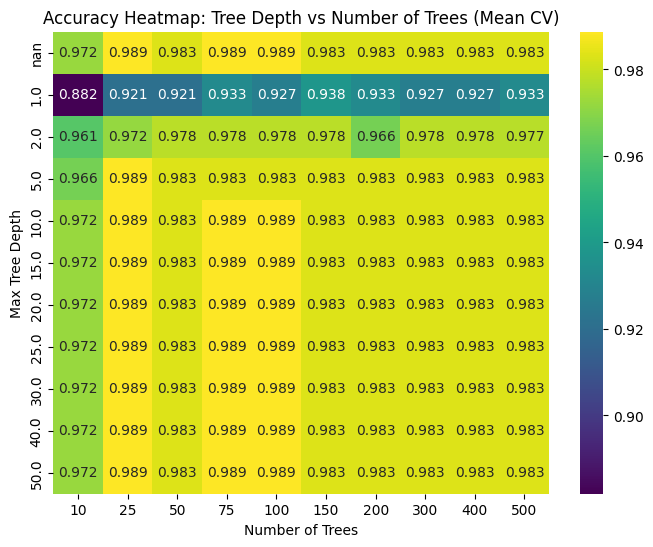

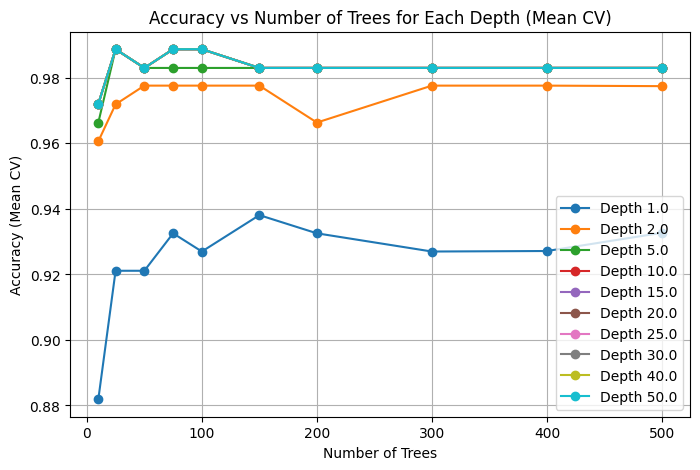

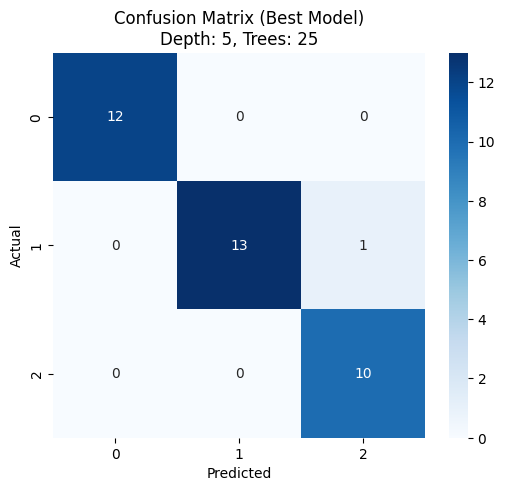

In [100]:
# Wine experiment
wine_depth_nest_metrics, wine_depth_nest_filename = run_depth_vs_n_estimators_experiment(
    X_wine_scaled, y_wine,
    dataset_name='wine'
)

visualize_depth_vs_n_estimators_results(wine_depth_nest_filename)

Depth: 1, Trees: 10, Accuracy: 0.721 ± 0.006, F1: 0.740 ± 0.005
Depth: 1, Trees: 25, Accuracy: 0.747 ± 0.006, F1: 0.763 ± 0.005
Depth: 1, Trees: 50, Accuracy: 0.743 ± 0.006, F1: 0.759 ± 0.006
Depth: 1, Trees: 75, Accuracy: 0.733 ± 0.005, F1: 0.750 ± 0.005
Depth: 1, Trees: 100, Accuracy: 0.739 ± 0.005, F1: 0.756 ± 0.004
Depth: 1, Trees: 150, Accuracy: 0.732 ± 0.006, F1: 0.750 ± 0.005
Depth: 1, Trees: 200, Accuracy: 0.732 ± 0.006, F1: 0.749 ± 0.005
Depth: 1, Trees: 300, Accuracy: 0.731 ± 0.006, F1: 0.748 ± 0.006
Depth: 1, Trees: 400, Accuracy: 0.732 ± 0.006, F1: 0.749 ± 0.005
Depth: 1, Trees: 500, Accuracy: 0.732 ± 0.005, F1: 0.750 ± 0.005
Depth: 2, Trees: 10, Accuracy: 0.744 ± 0.009, F1: 0.761 ± 0.008
Depth: 2, Trees: 25, Accuracy: 0.747 ± 0.005, F1: 0.763 ± 0.005
Depth: 2, Trees: 50, Accuracy: 0.745 ± 0.004, F1: 0.762 ± 0.004
Depth: 2, Trees: 75, Accuracy: 0.738 ± 0.006, F1: 0.755 ± 0.005
Depth: 2, Trees: 100, Accuracy: 0.738 ± 0.004, F1: 0.755 ± 0.004
Depth: 2, Trees: 150, Accuracy: 0

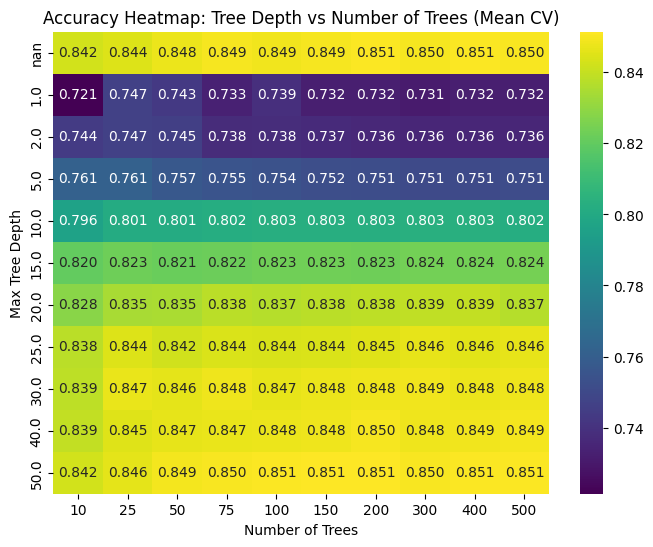

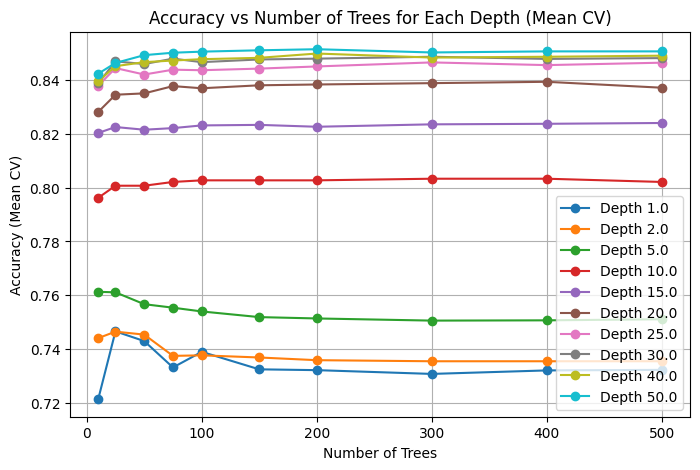

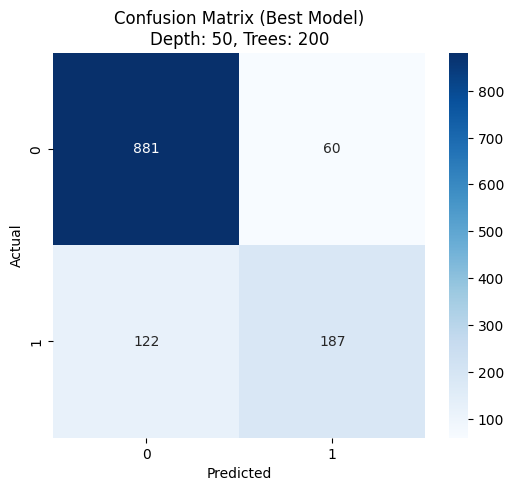

In [74]:
# Adult Income experiment
adult_adult_metrics, adult_filename = run_depth_vs_n_estimators_experiment(
    X_adult_processed, adult_target,
    dataset_name='adult_income'
)

visualize_depth_vs_n_estimators_results(adult_filename)

Depth: 1, Trees: 10, Accuracy: 0.479 ± 0.030, F1: 0.434 ± 0.038
Depth: 1, Trees: 25, Accuracy: 0.522 ± 0.021, F1: 0.473 ± 0.027
Depth: 1, Trees: 50, Accuracy: 0.521 ± 0.014, F1: 0.472 ± 0.018
Depth: 1, Trees: 75, Accuracy: 0.517 ± 0.009, F1: 0.461 ± 0.011
Depth: 1, Trees: 100, Accuracy: 0.526 ± 0.008, F1: 0.472 ± 0.010
Depth: 1, Trees: 150, Accuracy: 0.546 ± 0.009, F1: 0.500 ± 0.011
Depth: 1, Trees: 200, Accuracy: 0.542 ± 0.008, F1: 0.492 ± 0.009
Depth: 1, Trees: 300, Accuracy: 0.553 ± 0.007, F1: 0.507 ± 0.007
Depth: 1, Trees: 400, Accuracy: 0.565 ± 0.008, F1: 0.522 ± 0.007
Depth: 1, Trees: 500, Accuracy: 0.561 ± 0.009, F1: 0.518 ± 0.007
Depth: 2, Trees: 10, Accuracy: 0.588 ± 0.017, F1: 0.555 ± 0.017
Depth: 2, Trees: 25, Accuracy: 0.621 ± 0.015, F1: 0.588 ± 0.019
Depth: 2, Trees: 50, Accuracy: 0.641 ± 0.014, F1: 0.612 ± 0.018
Depth: 2, Trees: 75, Accuracy: 0.647 ± 0.007, F1: 0.619 ± 0.009
Depth: 2, Trees: 100, Accuracy: 0.652 ± 0.011, F1: 0.626 ± 0.013
Depth: 2, Trees: 150, Accuracy: 0

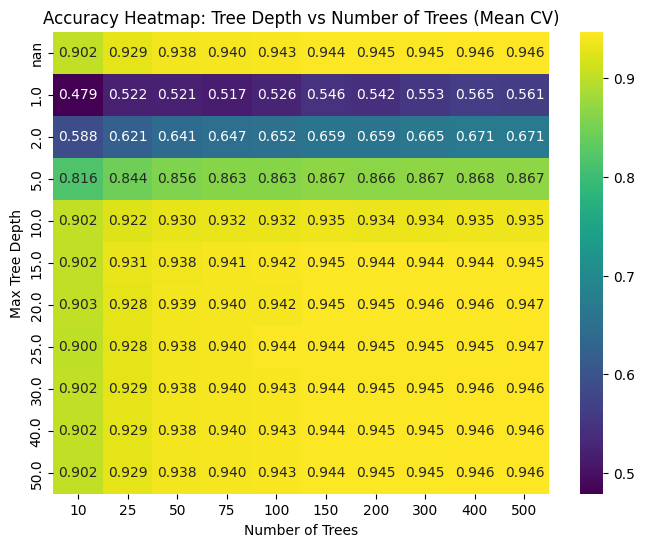

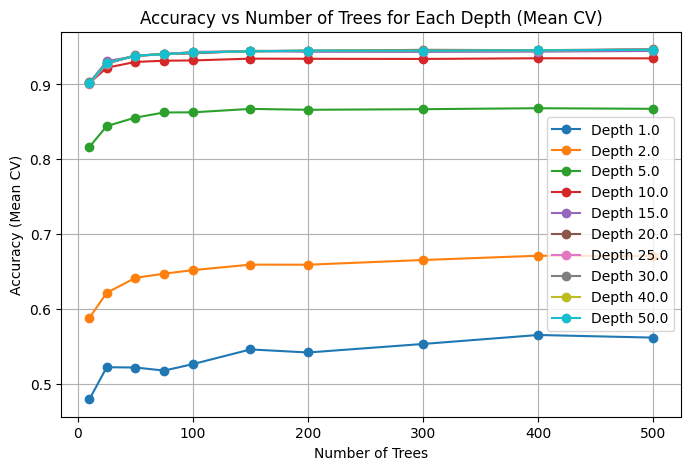

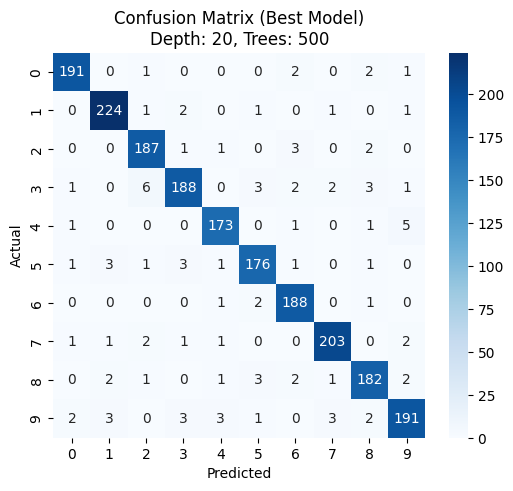

In [20]:
# MNIST experiment
mnist_metrics, mnist_filename = run_depth_vs_n_estimators_experiment(
    X_mnist_scaled, y_mnist,
    dataset_name='mnist'
)

visualize_depth_vs_n_estimators_results(mnist_filename)

In [110]:
def visualize_depth_vs_n_estimators_results_multiple(filenames, labels=None):
    """
    Plots heatmaps, line plots, and confusion matrices for all datasets,
    with each graph type on a separate sheet (figure).
    """
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    n = len(filenames)
    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(n)]

    dfs = []
    bests = []
    for filename in filenames:
        with open(filename, 'r') as f:
            metrics = json.load(f)
        df = pd.DataFrame(metrics)
        df['max_depth'] = df['max_depth'].replace('None', None)
        df['max_depth'] = df['max_depth'].apply(lambda x: int(x) if x is not None else None)
        dfs.append(df)
        bests.append(max(metrics, key=lambda m: m['accuracy_mean']))

    # Sheet 1: Heatmaps
    fig, axes = plt.subplots(1, n, figsize=(6*n, 6))
    if n == 1:
        axes = [axes]
    for i, (df, label) in enumerate(zip(dfs, labels)):
        heatmap_data = df.pivot(index='max_depth', columns='n_estimators', values='accuracy_mean')
        sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="viridis", ax=axes[i])
        axes[i].set_title(f"{label} - Accuracy Heatmap")
        axes[i].set_xlabel("Number of Trees")
        axes[i].set_ylabel("Max Tree Depth")
    plt.tight_layout()
    plt.show()

    # Sheet 2: Line plots
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    # Find min and max accuracy across all datasets for normalization
    acc_min = min(df['accuracy_mean'].min() for df in dfs)
    acc_max = max(df['accuracy_mean'].max() for df in dfs)
    for i, (df, label) in enumerate(zip(dfs, labels)):
        for depth in sorted(df['max_depth'].dropna().unique()):
            subset = df[df['max_depth'] == depth]
            # Normalize accuracy
            norm_acc = (subset['accuracy_mean'] - acc_min) / (acc_max - acc_min)
            axes[i].plot(subset['n_estimators'], norm_acc, marker='o', label=f'Depth {depth}')
        if None in df['max_depth'].values:
            subset = df[df['max_depth'].isnull()]
            norm_acc = (subset['accuracy_mean'] - acc_min) / (acc_max - acc_min)
            axes[i].plot(subset['n_estimators'], norm_acc, marker='o', label='Depth None')
        axes[i].set_xlabel('Number of Trees')
        axes[i].set_ylabel('Normalized Accuracy')
        axes[i].set_title(f"{label} - Normalized Accuracy vs Number of Trees")
        axes[i].legend()
        axes[i].grid(True)
        axes[i].set_ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Sheet 3: Confusion matrices
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for i, (best, label) in enumerate(zip(bests, labels)):
        cm = np.array(best['confusion_matrices'][0])
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"{label} - Confusion Matrix\nDepth: {best['max_depth']}, Trees: {best['n_estimators']}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

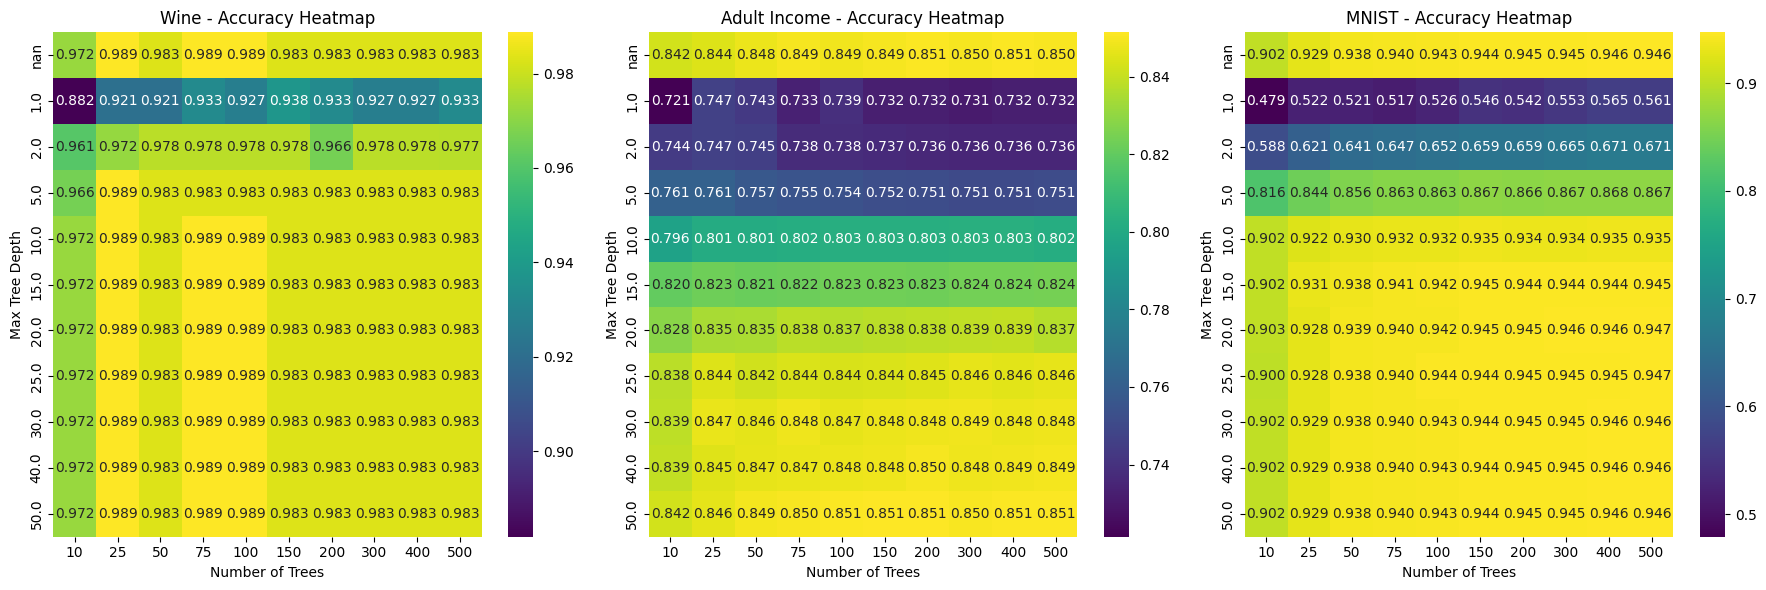

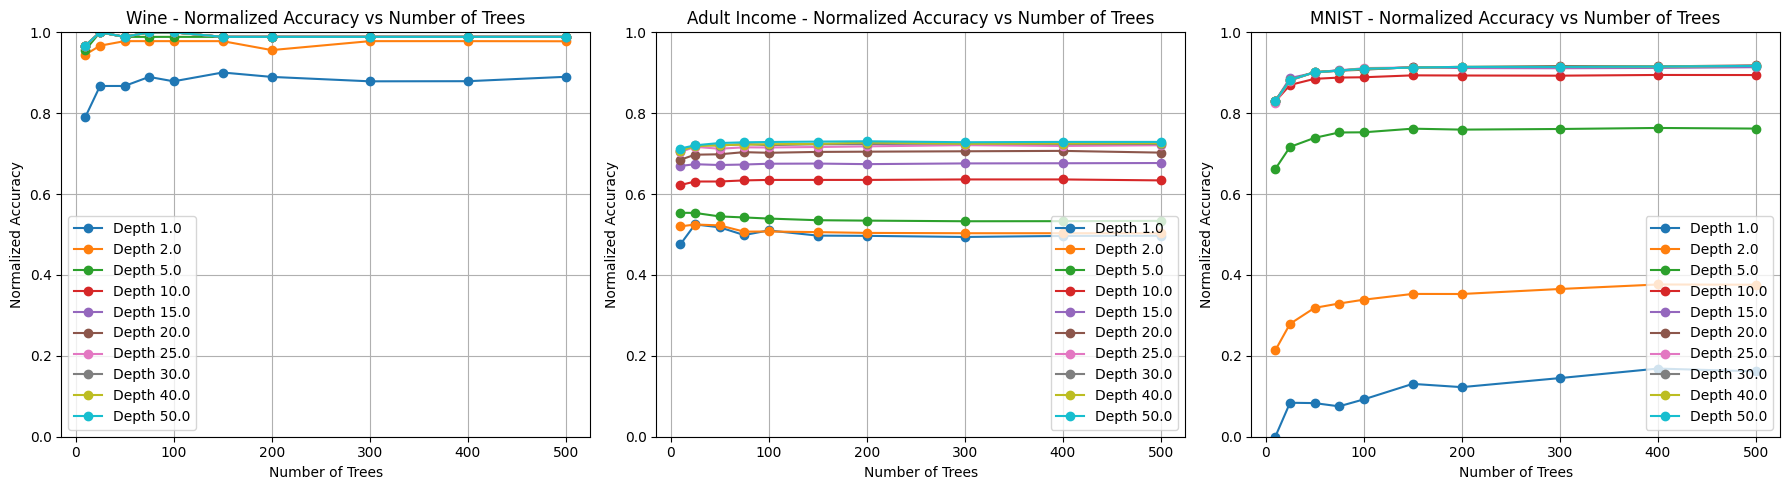

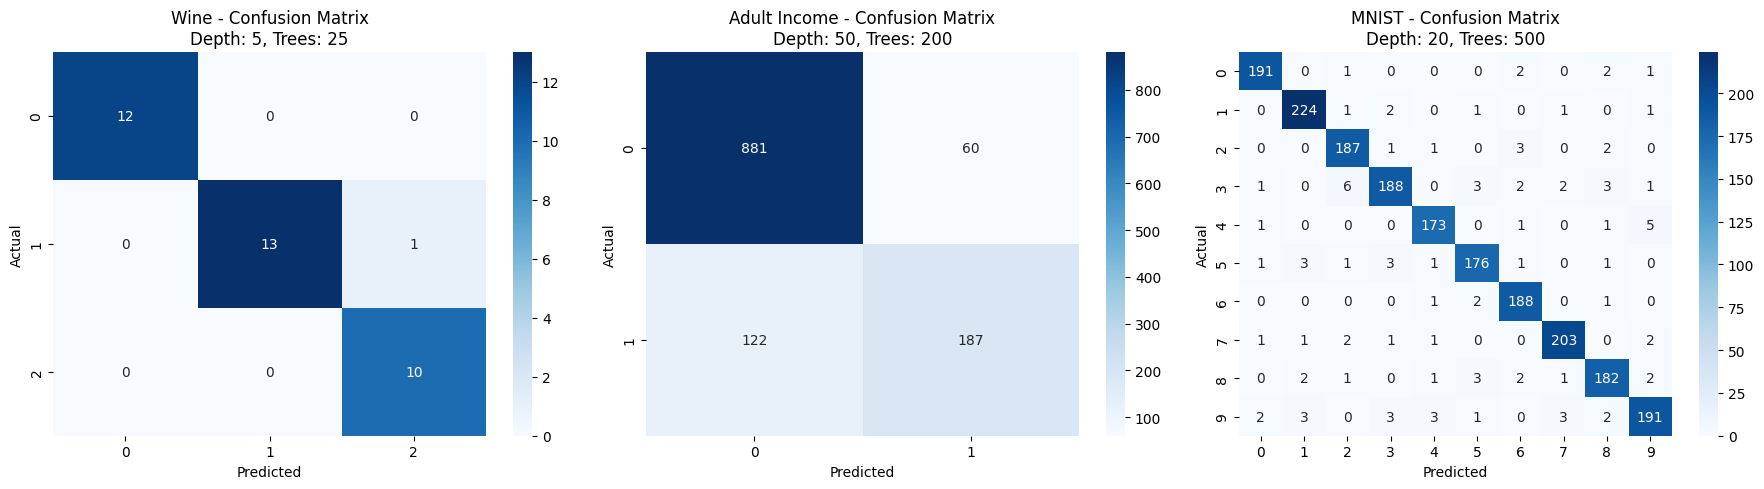

In [111]:
visualize_depth_vs_n_estimators_results_multiple(
    [wine_depth_nest_filename, "experiment_2/rf_depth_vs_n_estimators_cv__adult_income__20251021-101315.json", "experiment_2/rf_depth_vs_n_estimators_cv__mnist__20251020-100731.json"],
    labels=['Wine', 'Adult Income', 'MNIST']
)

## Experiment 3

Vary number of features to split on:

- Fix other parameters (max_depth = prev_best ??)

Results: accuracy vs number of features 

In [21]:
def plot_max_features_vs_accuracy(filename):
    # Load metrics from file
    with open(filename, 'r') as f:
        metrics = json.load(f)

    # Extract max_features and mean accuracies from CV
    max_features = [m['max_features'] for m in metrics]
    accuracies_mean = [m['accuracy_mean'] for m in metrics]
    accuracies_std = [m['accuracy_std'] for m in metrics]

    plt.figure(figsize=(8, 5))
    plt.errorbar(max_features, accuracies_mean, yerr=accuracies_std, marker='o', capsize=4)
    plt.xlabel('Max Features to Split On')
    plt.ylabel('Accuracy (Mean ± Std, CV)')
    plt.title('Accuracy vs Number of Features to Split On (Cross-Validation)')
    plt.grid(True)
    plt.show()

In [88]:
def run_max_features_experiment(
    X, y,
    max_features_list=['sqrt', 'log2', None, 0.25, 0.5, 1, 5, 10, 20, 50, 100],
    n_estimators=100,
    max_depth=None,
    random_state=42,
    results_dir='experiment_3',
    dataset_name='dataset',
    cv=8
):
    """
    Runs an experiment varying max_features for a Random Forest using cross-validation.
    Saves metrics to a JSON file with a timestamp.
    Returns a list of metrics for plotting.
    """
    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for max_features in max_features_list:
        fold_accuracies = []
        fold_f1s = []
        fold_stddevs = []
        fold_cms = []
        for train_idx, test_idx in skf.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            clf = RandomForestClassifier(
                n_estimators=n_estimators,
                max_depth=max_depth,
                max_features=max_features,
                random_state=random_state,
                class_weight='balanced'
            )
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            acc = accuracy_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred, average='weighted')
            cm = confusion_matrix(y_test, y_pred)
            if hasattr(clf, "predict_proba"):
                proba = clf.predict_proba(X_test)
                std_dev = float(np.std(proba))
            else:
                std_dev = None
            fold_accuracies.append(acc)
            fold_f1s.append(f1)
            fold_stddevs.append(std_dev)
            fold_cms.append(cm.tolist())
        metrics.append({
            'max_features': str(max_features),
            'accuracy_mean': np.mean(fold_accuracies),
            'accuracy_std': np.std(fold_accuracies),
            'f1_mean': np.mean(fold_f1s),
            'f1_std': np.std(fold_f1s),
            'std_dev_mean': np.mean([v for v in fold_stddevs if v is not None]),
            'std_dev_std': np.std([v for v in fold_stddevs if v is not None]),
            'confusion_matrices': fold_cms
        })
        print(f"Max Features: {max_features}, Accuracy: {np.mean(fold_accuracies):.3f} ± {np.std(fold_accuracies):.3f}, F1: {np.mean(fold_f1s):.3f} ± {np.std(fold_f1s):.3f}")
    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/rf_max_features_cv_metrics__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump(metrics, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

Max Features: sqrt, Accuracy: 0.955 ± 0.031, F1: 0.955 ± 0.032
Max Features: log2, Accuracy: 0.955 ± 0.031, F1: 0.955 ± 0.032
Max Features: None, Accuracy: 0.949 ± 0.036, F1: 0.949 ± 0.036
Max Features: 0.25, Accuracy: 0.955 ± 0.031, F1: 0.955 ± 0.032
Max Features: 0.5, Accuracy: 0.972 ± 0.022, F1: 0.972 ± 0.022
Max Features: 1, Accuracy: 0.983 ± 0.022, F1: 0.983 ± 0.022
Max Features: 5, Accuracy: 0.972 ± 0.032, F1: 0.972 ± 0.032
Max Features: 10, Accuracy: 0.960 ± 0.042, F1: 0.961 ± 0.042
Max Features: 20, Accuracy: 0.949 ± 0.036, F1: 0.949 ± 0.036
Max Features: 50, Accuracy: 0.949 ± 0.036, F1: 0.949 ± 0.036
Max Features: 100, Accuracy: 0.949 ± 0.036, F1: 0.949 ± 0.036
Metrics saved to experiment_3/rf_max_features_cv_metrics__wine__20251021-110225.json


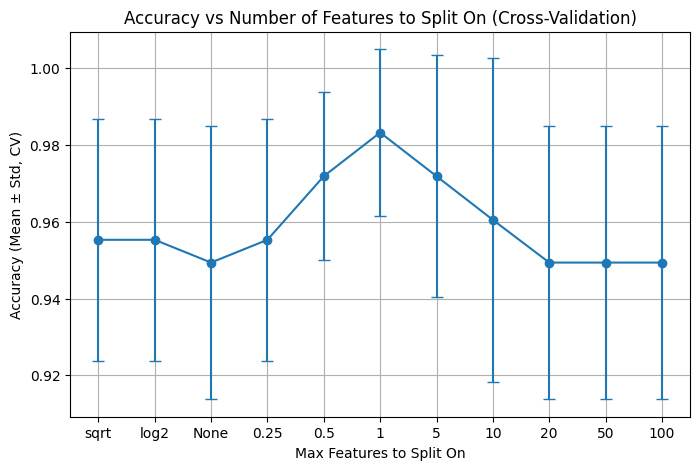

In [106]:
# wine experiment for max_features
wine_maxfeat_metrics, wine_maxfeat_filename = run_max_features_experiment(
    X_wine_scaled, y_wine,
    dataset_name='wine',
    n_estimators=25,
    max_depth=2
)

plot_max_features_vs_accuracy(wine_maxfeat_filename)

Max Features: sqrt, Accuracy: 0.823 ± 0.004, F1: 0.831 ± 0.004
Max Features: log2, Accuracy: 0.809 ± 0.008, F1: 0.819 ± 0.007
Max Features: None, Accuracy: 0.840 ± 0.005, F1: 0.845 ± 0.005
Max Features: 0.25, Accuracy: 0.835 ± 0.005, F1: 0.841 ± 0.005
Max Features: 0.5, Accuracy: 0.839 ± 0.006, F1: 0.844 ± 0.005
Max Features: 1, Accuracy: 0.770 ± 0.006, F1: 0.784 ± 0.005
Max Features: 5, Accuracy: 0.804 ± 0.009, F1: 0.814 ± 0.009
Max Features: 10, Accuracy: 0.823 ± 0.004, F1: 0.831 ± 0.004
Max Features: 20, Accuracy: 0.829 ± 0.007, F1: 0.836 ± 0.006
Max Features: 50, Accuracy: 0.838 ± 0.006, F1: 0.843 ± 0.005
Max Features: 100, Accuracy: 0.841 ± 0.005, F1: 0.846 ± 0.004
Metrics saved to experiment_3/rf_max_features_cv_metrics__adult_income__20251021-110303.json


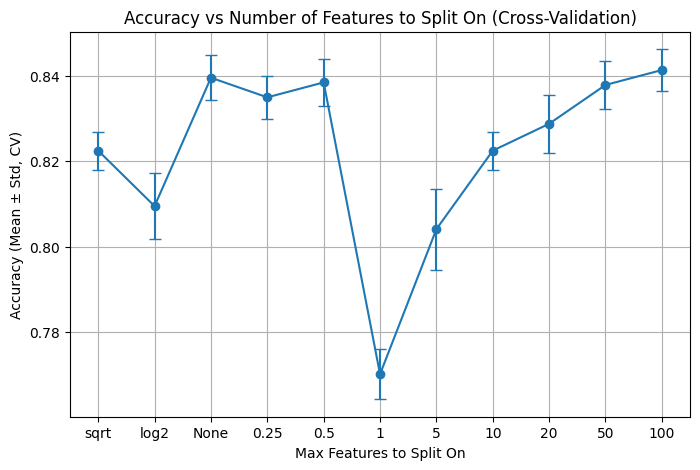

In [107]:
# Adult Income experiment
adult_maxfeat_metrics, adult_maxfeat_filename = run_max_features_experiment(
    X_adult_processed, adult_target,
    dataset_name='adult_income',
    n_estimators=25,
    max_depth=15
)

plot_max_features_vs_accuracy(adult_maxfeat_filename)

In [ ]:
# MNIST experiment
mnist_metrics, mnist_filename = run_max_features_experiment(
    X_mnist_scaled, y_mnist,
    dataset_name='mnist',
    n_estimators=100,
    max_depth=10
)

plot_max_features_vs_accuracy(mnist_filename)

In [96]:
def plot_max_features_vs_accuracy_multiple(filenames, labels=None):
    """
    Plots accuracy vs max_features for multiple datasets on the same axes,
    with normalized y-axis for comparison.
    filenames: list of JSON metric files (from run_max_features_experiment)
    labels: list of labels for each dataset (optional)
    """
    import json
    import matplotlib.pyplot as plt

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(filenames))]

    all_max_features = []
    all_accuracies_mean = []
    all_accuracies_std = []

    # Collect all metrics for normalization
    for filename in filenames:
        with open(filename, 'r') as f:
            metrics = json.load(f)
        max_features = [m['max_features'] for m in metrics]
        accuracies_mean = [m['accuracy_mean'] for m in metrics]
        accuracies_std = [m['accuracy_std'] for m in metrics]
        all_max_features.append(max_features)
        all_accuracies_mean.append(accuracies_mean)
        all_accuracies_std.append(accuracies_std)

    # Normalize y-axis
    # y_min = min(min(acc) for acc in all_accuracies_mean)
    # y_max = max(max(acc) for acc in all_accuracies_mean)

    plt.figure(figsize=(10, 6))
    for i in range(len(filenames)):
        plt.errorbar(
            all_max_features[i], all_accuracies_mean[i], yerr=all_accuracies_std[i],
            marker='o', capsize=4, label=labels[i]
        )
    plt.xlabel('Max Features to Split On')
    plt.ylabel('Accuracy (Mean ± Std, CV)')
    # plt.title('Accuracy vs Number of Features to Split On (All Datasets)')
    plt.grid(True)
    plt.legend()
    # plt.ylim(y_min, y_max)
    plt.show()

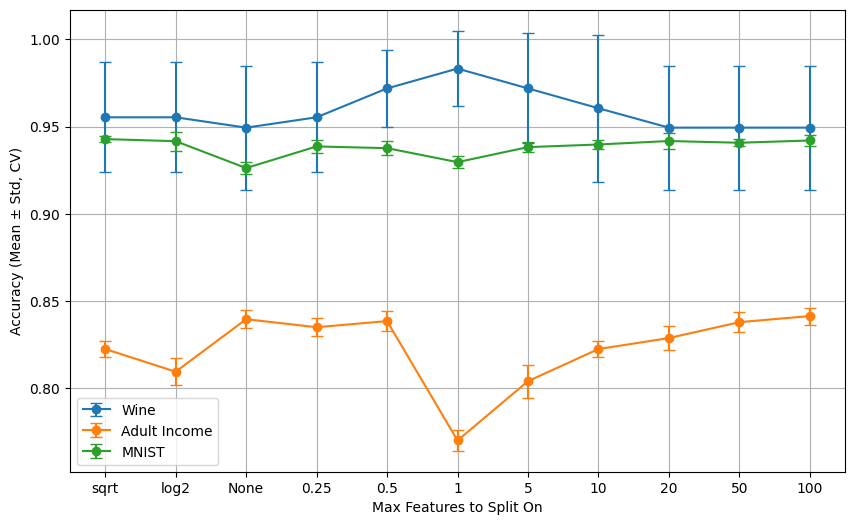

In [ ]:
plot_max_features_vs_accuracy_multiple(
    [wine_maxfeat_filename, adult_maxfeat_filename, mnist_filename],
    labels=['Wine', 'Adult Income', 'MNIST']
)

## Experiment 4

Full parameter exploration

- Vary tree depths and number of features per split for each tree in random forest.
- Have overfitting and underfitting trees in the forest.

Results: heatmap or 3D surface plot (accuracy as function of depth and features).

In [77]:
def run_mixed_rf_experiment(
    X, y,
    depths=[2, 5, 10, 15, 20, 25, 30, 40, 50, None],  
    max_features_list=['sqrt', 'log2', 0.25, 0.5, 0.75, 1, 5, 10, 20, None],
    n_estimators=20,  # Number of trees in forest
    random_state=42,
    cv=8,
    results_dir='experiment_4',
    dataset_name='dataset'
):
    """
    Runs a Random Forest experiment where each tree has different parameters (depth, max_features).
    Performs cross-validation, tracks metrics, and saves results to a file.
    """

    X = np.asarray(X)
    y = np.asarray(y)

    metrics = []
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    rng = np.random.RandomState(random_state)

    # Prepare list of (depth, max_features) for each tree
    param_combos = list(itertools.product(depths, max_features_list))
    # If less combos than n_estimators, repeat combos
    combos = (param_combos * ((n_estimators // len(param_combos)) + 1))[:n_estimators]

    n_classes = len(np.unique(y))

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Build custom forest: each tree with different params
        trees = []
        for i, (depth, max_features) in enumerate(combos):
            tree = DecisionTreeClassifier(
                max_depth=depth,
                max_features=max_features,
                random_state=rng.randint(1_000_000)
            )
            trees.append(tree)

        # Fit each tree on a bootstrap sample
        preds = np.zeros((X_test.shape[0], n_estimators, n_classes))
        for i, tree in enumerate(trees):
            idxs = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
            tree.fit(X_train[idxs], y_train[idxs])

            raw_proba = tree.predict_proba(X_test)
            proba = np.zeros((X_test.shape[0], n_classes))
            for class_idx, class_label in enumerate(tree.classes_):
                proba[:, class_label] = raw_proba[:, class_idx]
            preds[:, i, :] = proba


        # Aggregate predictions (majority vote)
        avg_proba = np.mean(preds, axis=1)
        y_pred = np.argmax(avg_proba, axis=1)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        std_dev = float(np.std(avg_proba))
        tree_var = np.var(preds, axis=1).mean()

        metrics.append({
            'fold': fold,
            'accuracy': acc,
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'std_dev': std_dev,
            'confusion_matrix': cm.tolist(),
            'diversity': tree_var
        })
        print(f"Fold {fold}: Accuracy={acc:.3f}, F1={f1:.3f}")

    # Save metrics to file
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    filename = f"{results_dir}/mixed_rf_metrics__{dataset_name}__{timestamp}.json"
    os.makedirs(results_dir, exist_ok=True)
    with open(filename, 'w') as f:
        json.dump({'params_used': combos, 'metrics': metrics}, f, indent=2)
    print(f"Metrics saved to {filename}")

    return metrics, filename

In [78]:
def visualize_mixed_rf_results(filename):
    """
    Visualizes results from run_mixed_rf_experiment.
    Shows accuracy, F1, precision, recall across folds, confusion matrix for best fold,
    diversity, std_dev, and parameter distribution of trees in the ensemble.
    """
    import json
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Load metrics and params
    with open(filename, 'r') as f:
        data = json.load(f)
    metrics = data['metrics']
    params_used = data['params_used']

    # Convert metrics to DataFrame for easier plotting
    df = pd.DataFrame(metrics)

    # Plot accuracy, F1, precision, recall across folds
    plt.figure(figsize=(10, 5))
    plt.plot(df['fold'], df['accuracy'], marker='o', label='Accuracy')
    plt.plot(df['fold'], df['f1'], marker='s', label='F1 Score')
    plt.plot(df['fold'], df['precision'], marker='^', label='Precision')
    plt.plot(df['fold'], df['recall'], marker='x', label='Recall')
    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title('Metrics Across Folds')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot confusion matrix for best fold (highest accuracy)
    best_idx = df['accuracy'].idxmax()
    best_cm = np.array(df.loc[best_idx, 'confusion_matrix'])
    plt.figure(figsize=(6, 5))
    sns.heatmap(best_cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix (Best Fold: {df.loc[best_idx, 'fold']})")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Plot std_dev (uncertainty) and diversity across folds
    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(df['fold'], df['std_dev'], marker='o', color='purple', label='Std Dev')
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('Std Dev of Predicted Probabilities', color='purple')
    ax1.tick_params(axis='y', labelcolor='purple')
    ax2 = ax1.twinx()
    ax2.plot(df['fold'], df['diversity'], marker='s', color='green', label='Diversity')
    ax2.set_ylabel('Tree Diversity (Mean Variance)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    plt.title('Uncertainty and Diversity Across Folds')
    fig.tight_layout()
    plt.show()

    # # Visualize tree parameter distribution (depth, max_features)
    # param_df = pd.DataFrame(params_used, columns=['max_depth', 'max_features'])
    # plt.figure(figsize=(10, 5))
    # sns.countplot(x='max_depth', hue='max_features', data=param_df)
    # plt.title('Distribution of Tree Parameters in Ensemble')
    # plt.xlabel('Max Depth')
    # plt.ylabel('Count')
    # plt.legend(title='Max Features', bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.tight_layout()
    # plt.show()

Fold 0: Accuracy=1.000, F1=1.000
Fold 1: Accuracy=0.957, F1=0.956
Fold 2: Accuracy=1.000, F1=1.000
Fold 3: Accuracy=0.955, F1=0.955
Fold 4: Accuracy=0.955, F1=0.955
Fold 5: Accuracy=0.955, F1=0.955
Fold 6: Accuracy=0.955, F1=0.954
Fold 7: Accuracy=1.000, F1=1.000
Metrics saved to experiment_4/mixed_rf_metrics__wine__20251021-101400.json


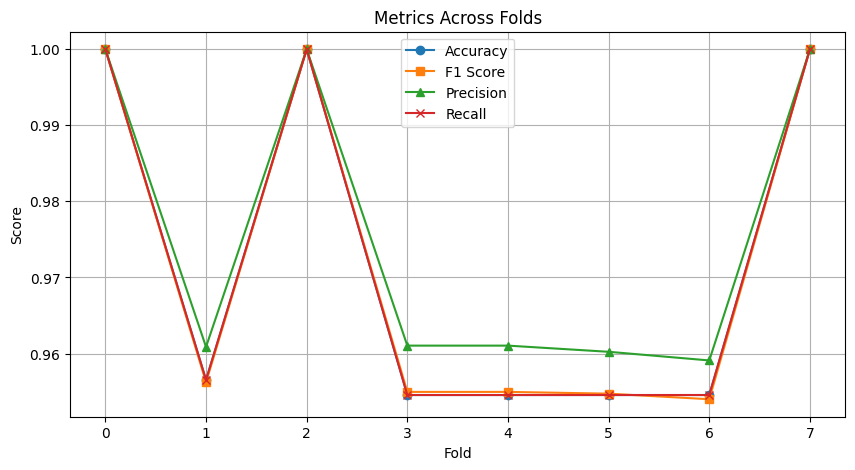

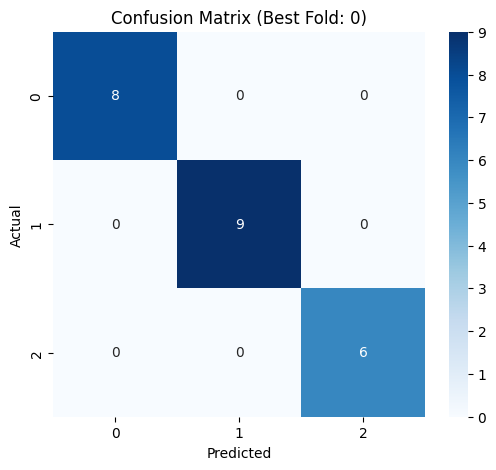

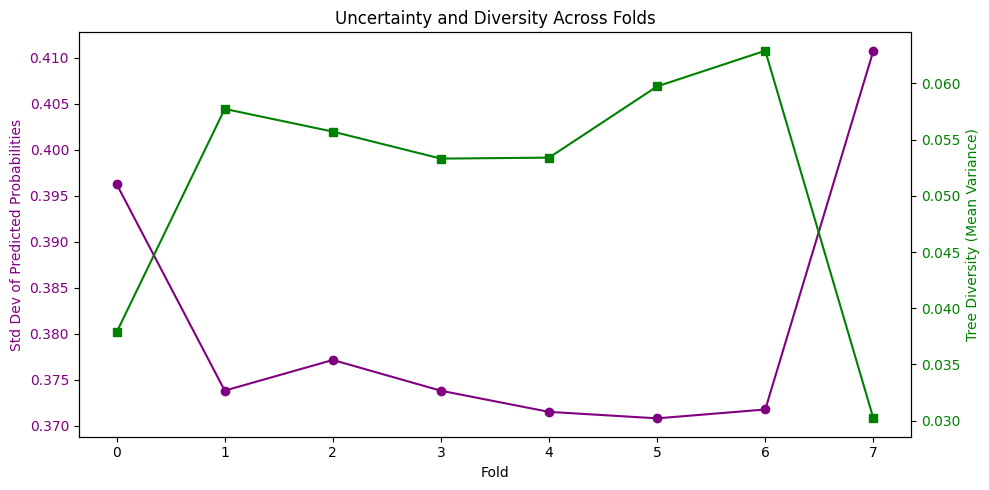

In [79]:
# Wine dataset mixed RF experiment
wine_mixed_metrics, wine_mixed_filename = run_mixed_rf_experiment(
    X_wine_scaled, y_wine,
    dataset_name='wine'
)

visualize_mixed_rf_results(wine_mixed_filename)

Fold 0: Accuracy=0.839, F1=0.823
Fold 1: Accuracy=0.835, F1=0.818
Fold 2: Accuracy=0.841, F1=0.816
Fold 3: Accuracy=0.842, F1=0.820
Fold 4: Accuracy=0.842, F1=0.825
Fold 5: Accuracy=0.824, F1=0.788
Fold 6: Accuracy=0.816, F1=0.773
Fold 7: Accuracy=0.846, F1=0.828
Metrics saved to experiment_4/mixed_rf_metrics__adult_income__20251021-101409.json


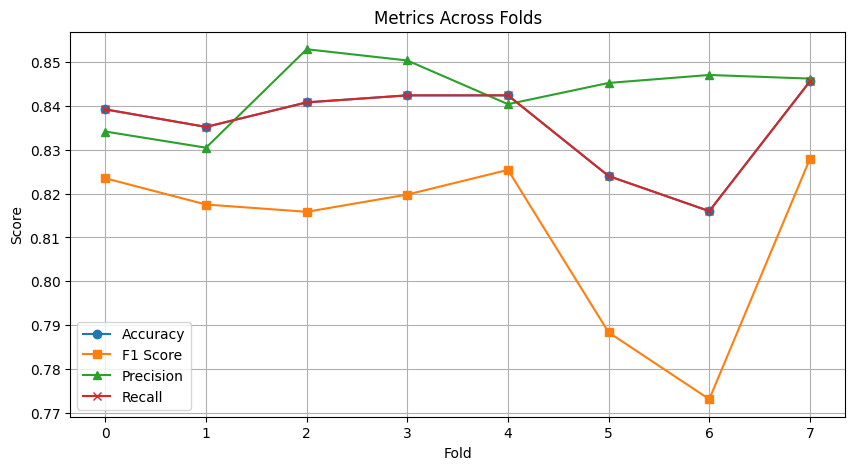

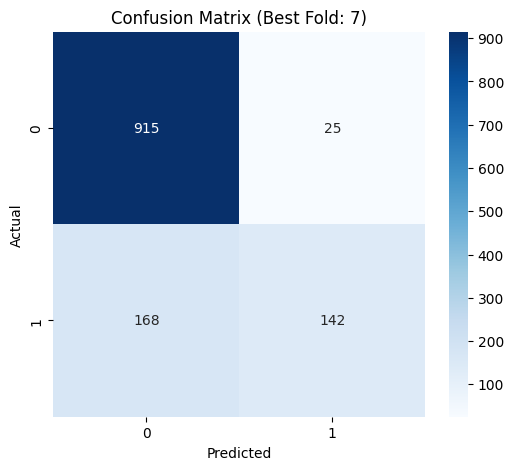

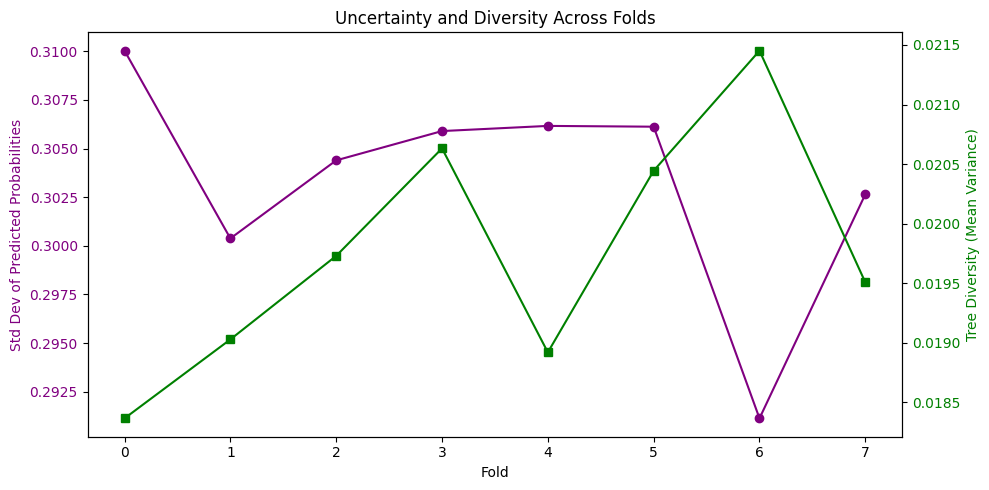

In [80]:
# Adult income mixed RF experiment
adult_mixed_metrics, adult_mixed_filename = run_mixed_rf_experiment(
    X_adult_processed.toarray(), adult_target,
    dataset_name='adult_income'
)

visualize_mixed_rf_results(adult_mixed_filename)

Fold 0: Accuracy=0.780, F1=0.773
Fold 1: Accuracy=0.802, F1=0.799
Fold 2: Accuracy=0.789, F1=0.786
Fold 3: Accuracy=0.789, F1=0.784
Fold 4: Accuracy=0.799, F1=0.797
Fold 5: Accuracy=0.752, F1=0.741
Fold 6: Accuracy=0.775, F1=0.771
Fold 7: Accuracy=0.802, F1=0.800
Metrics saved to experiment_4/mixed_rf_metrics__mnist__20251021-101426.json


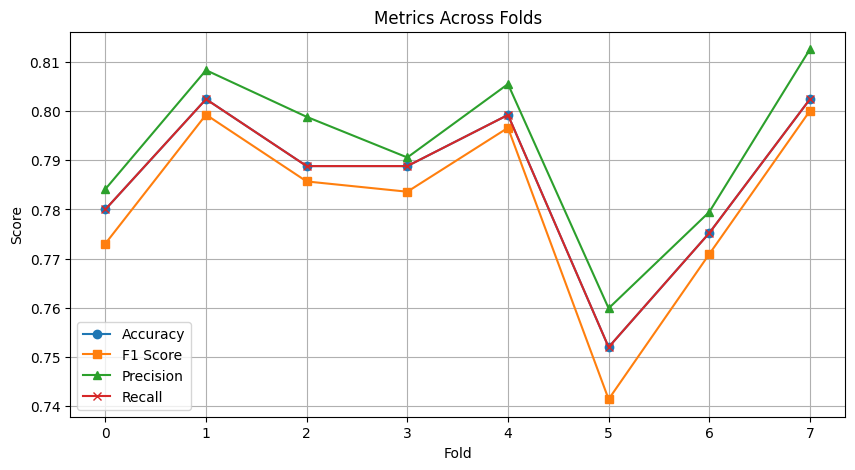

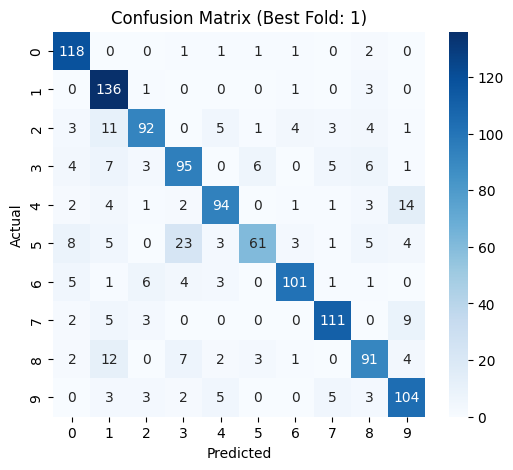

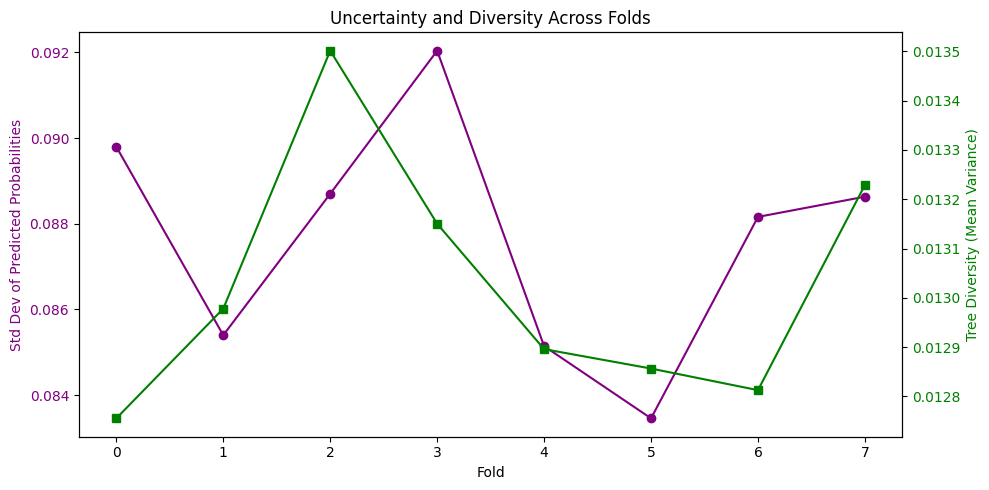

In [81]:
# Mnist mixed RF experiment
mnist_mixed_metrics, mnist_mixed_filename = run_mixed_rf_experiment(
    X_mnist_scaled, y_mnist,
    dataset_name='mnist'   
)

visualize_mixed_rf_results(mnist_mixed_filename)

In [83]:
def compare_mixed_rf_results(filenames, labels=None):
    """
    Plots metrics from multiple mixed RF experiment results on shared grids with normalized axes:
    - All confusion matrices (best fold) in a row
    - All std_dev and diversity plots in a row (y-axes normalized)
    - All accuracy/F1/precision/recall vs fold plots in a row (y-axes normalized)

    filenames: list of JSON files (from run_mixed_rf_experiment)
    labels: list of dataset names (optional)
    """

    if labels is None:
        labels = [f"Dataset {i+1}" for i in range(len(filenames))]

    n = len(filenames)
    dfs = []
    best_cms = []
    best_idxs = []

    # Load all results
    for filename in filenames:
        with open(filename, 'r') as f:
            data = json.load(f)
        df = pd.DataFrame(data['metrics'])
        dfs.append(df)
        best_idx = df['accuracy'].idxmax()
        best_idxs.append(best_idx)
        best_cms.append(np.array(df.loc[best_idx, 'confusion_matrix']))

    # Plot all confusion matrices
    fig, axes = plt.subplots(1, n, figsize=(6*n, 5))
    if n == 1:
        axes = [axes]
    for i, (cm, label) in enumerate(zip(best_cms, labels)):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
        axes[i].set_title(f"{label}\nConfusion Matrix (Best Fold)")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Normalize y-axis for std_dev and diversity
    std_dev_min = min(df['std_dev'].min() for df in dfs)
    std_dev_max = max(df['std_dev'].max() for df in dfs)
    diversity_min = min(df['diversity'].min() for df in dfs)
    diversity_max = max(df['diversity'].max() for df in dfs)

    # Plot all std_dev and diversity plots
    fig, axes = plt.subplots(1, n, figsize=(7*n, 5))
    if n == 1:
        axes = [axes]
    for i, (df, label) in enumerate(zip(dfs, labels)):
        ax1 = axes[i]
        ax2 = ax1.twinx()
        ax1.plot(df['fold'], df['std_dev'], marker='o', color='purple', label='Std Dev')
        ax2.plot(df['fold'], df['diversity'], marker='s', color='green', label='Diversity')
        ax1.set_xlabel('Fold')
        ax1.set_ylabel('Std Dev', color='purple')
        ax2.set_ylabel('Diversity', color='green')
        ax1.tick_params(axis='y', labelcolor='purple')
        ax2.tick_params(axis='y', labelcolor='green')
        ax1.set_title(f"{label}\nUncertainty & Diversity")
        ax1.set_ylim(std_dev_min, std_dev_max)
        ax2.set_ylim(diversity_min, diversity_max)
    plt.tight_layout()
    plt.show()

    # Normalize y-axis for metrics
    score_min = min(min(df[c].min() for c in ['accuracy', 'f1', 'precision', 'recall']) for df in dfs)
    score_max = max(max(df[c].max() for c in ['accuracy', 'f1', 'precision', 'recall']) for df in dfs)

    # Plot all accuracy/F1/precision/recall vs fold plots
    fig, axes = plt.subplots(1, n, figsize=(7*n, 5))
    if n == 1:
        axes = [axes]
    for i, (df, label) in enumerate(zip(dfs, labels)):
        ax = axes[i]
        ax.plot(df['fold'], df['accuracy'], marker='o', label='Accuracy')
        ax.plot(df['fold'], df['f1'], marker='s', label='F1')
        ax.plot(df['fold'], df['precision'], marker='^', label='Precision')
        ax.plot(df['fold'], df['recall'], marker='x', label='Recall')
        ax.set_xlabel('Fold')
        ax.set_ylabel('Score')
        ax.set_title(f"{label}\nMetrics Across Folds")
        ax.legend()
        ax.grid(True)
        ax.set_ylim(score_min, score_max)
    plt.tight_layout()
    plt.show()

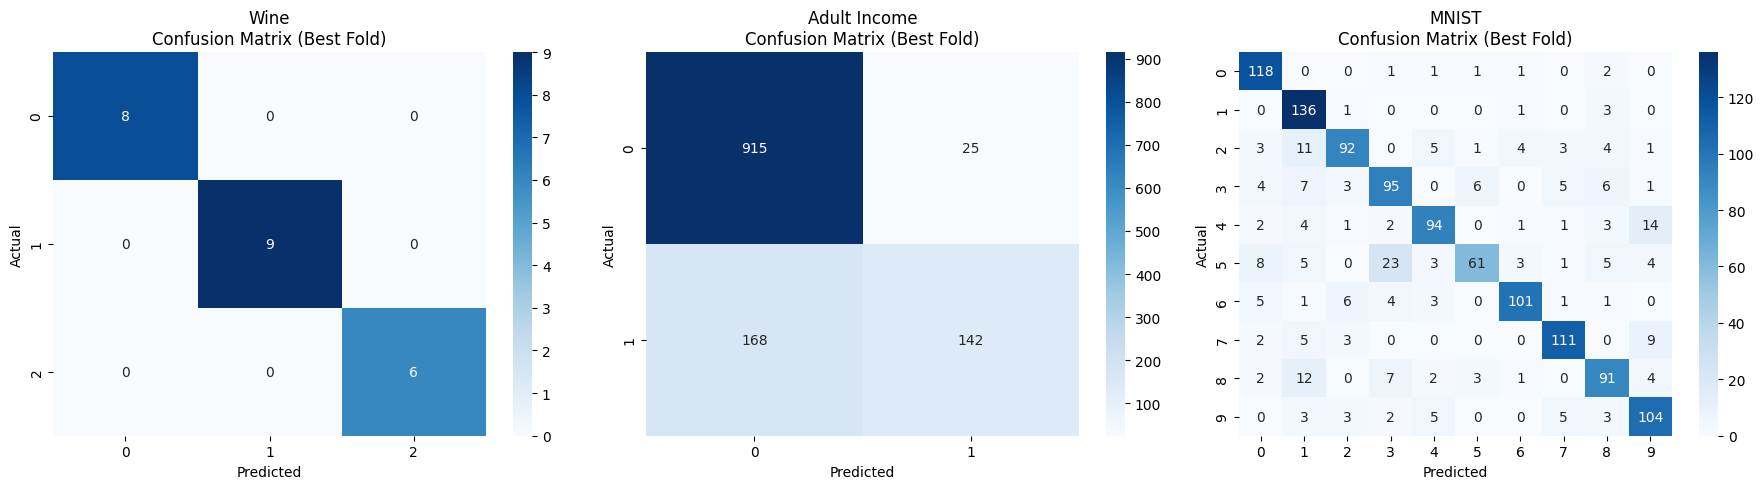

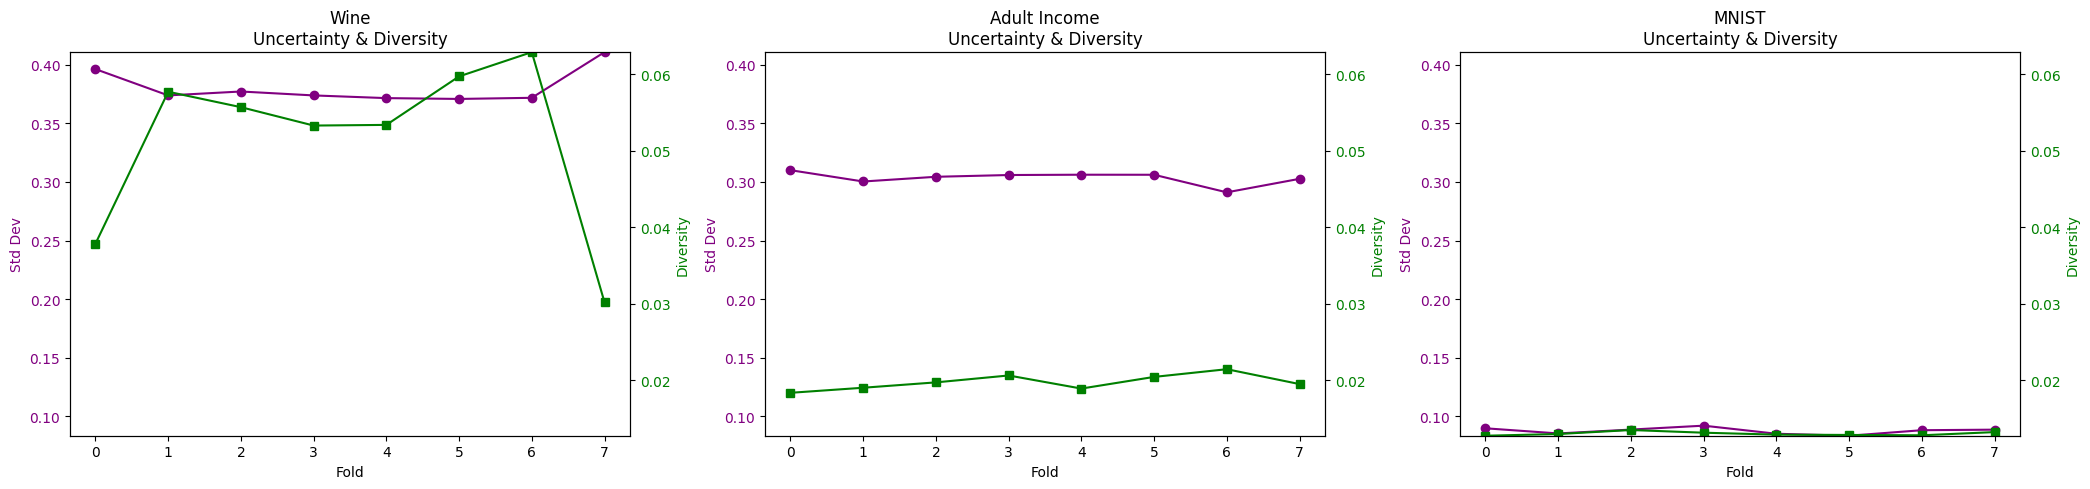

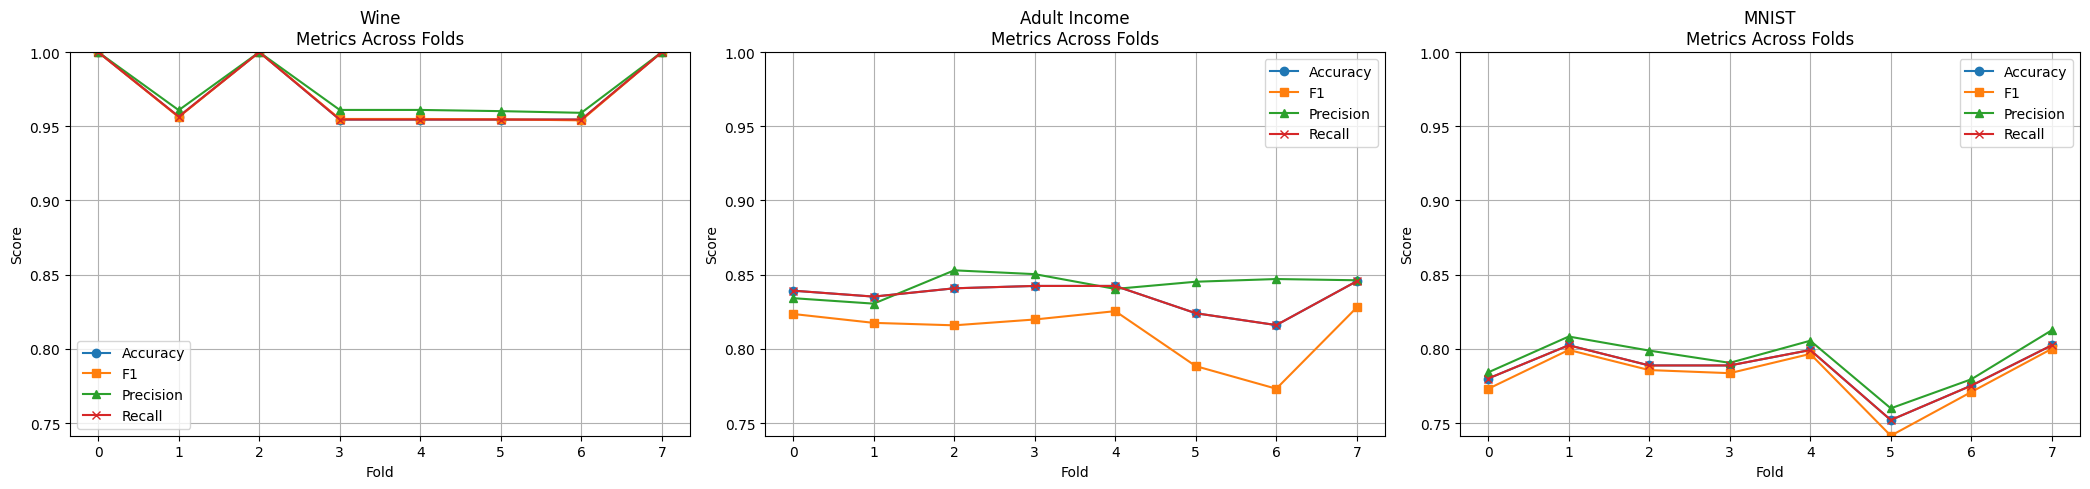

In [84]:
compare_mixed_rf_results(
    [wine_mixed_filename, adult_mixed_filename, mnist_mixed_filename],
    labels=['Wine', 'Adult Income', 'MNIST']
)